In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['axes.linewidth'] = .5
plt.rcParams['xtick.major.width'] = .5
plt.rcParams['ytick.major.width'] = .5
plt.rcParams['xtick.minor.width'] = .0
plt.rcParams['ytick.minor.width'] = .0
plt.rcParams['axes.labelpad'] = 1
plt.rcParams['axes.titlepad'] = 3
fontsize=6

In [2]:
import torch
import os, sys
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
qualitative = os.path.abspath('')
e_vae_proj = os.path.dirname(qualitative)
disvae = os.path.dirname(e_vae_proj)
if not disvae in sys.path: sys.path.append(disvae)
from utils.datasets import get_dataloaders
from disvae.utils.modelIO import load_model

# constraint
cons='kl'

In [3]:
seed_model = 1234
nlat = 10
batchs = 64
epochs = 200
lrs = [0.0005, 0.001]
increments = [4, 2]
if cons == "rec":
    epsilon = 30
else:
    epsilon = 0.08

In [4]:
# get visualisation data
n_data = 1
seed_data = 14
torch.manual_seed(seed_data)
dataloader = get_dataloaders('celeba', batch_size=n_data*n_data)
data = next(iter(dataloader))[0]
img_data = np.zeros((3, 64 * n_data, 64 * n_data))
for i in range(n_data):
    for j in range(n_data):
        img_data[:, (i * 64):(i * 64 + 64), (j * 64):(j * 64 + 64)] = data[i * n_data + j, :, :, :]

In [10]:
def plot_traversals(model_path, data, lr, incr, n_stddevs=14):
    # load model & get (reconstructions, latent posteriors, latent_sample) for data
    model = load_model(model_path, gpu_id=-1)
    with torch.no_grad():
        # collect latent samples for one image (1, 10)
        recons, lat_dist, lat_samples = model(data)
    lat_samples = lat_samples[0].numpy()
    means = lat_dist[0][0].numpy()
    log_vars = lat_dist[1][0].numpy()
    
    # vary the latent sample based on the given latent posteriors & get reconstructions
    N = 64 * n_data
    n_sample_vals = 10
    imgs = np.zeros((3, lat_samples.shape[0] * N, n_sample_vals * N))
    for i, z0 in enumerate(lat_samples):
        for j, z in enumerate(np.linspace(
                means[i] - n_stddevs * np.exp(0.5 * log_vars[i]), 
                means[i] + n_stddevs * np.exp(0.5 * log_vars[i]), 
                n_sample_vals)):
            lat_samples[i] = z
            with torch.no_grad():
                small_img = model.decoder(
                    torch.from_numpy(np.expand_dims(lat_samples, axis=0))
                ).numpy().squeeze()
                imgs[:, (i * N):(i * N + N), (j * N):(j * N + N)] = np.flip(small_img, 1)
            lat_samples[i] = z0
    
    # plot grid of varying latent_sample (x), latent_variable (y)
    figure, axes = plt.subplots(nrows=2, ncols=1, gridspec_kw={'height_ratios': [1, 8]},
                                dpi=300, facecolor='w')
    ax = axes[0]
    ax.imshow(img_data.transpose(1,2,0),)# origin='lower', )
    ax.axis('off')
    ax.text(-110, 40, 'Input:', fontsize=fontsize)

    ax = axes[1]
    ax.imshow(imgs.transpose(1,2,0), origin='lower', )
    ax.grid(which='minor', c='gray', lw=.5)
    ax.axis('off')
    ax.set_title('Traversals', fontsize=fontsize)
    plt.savefig(f'figures/traversals_kl_lr{lr}_incr{incr}.pdf', bbox_inches='tight', pad_inches=0.05)
    plt.show()

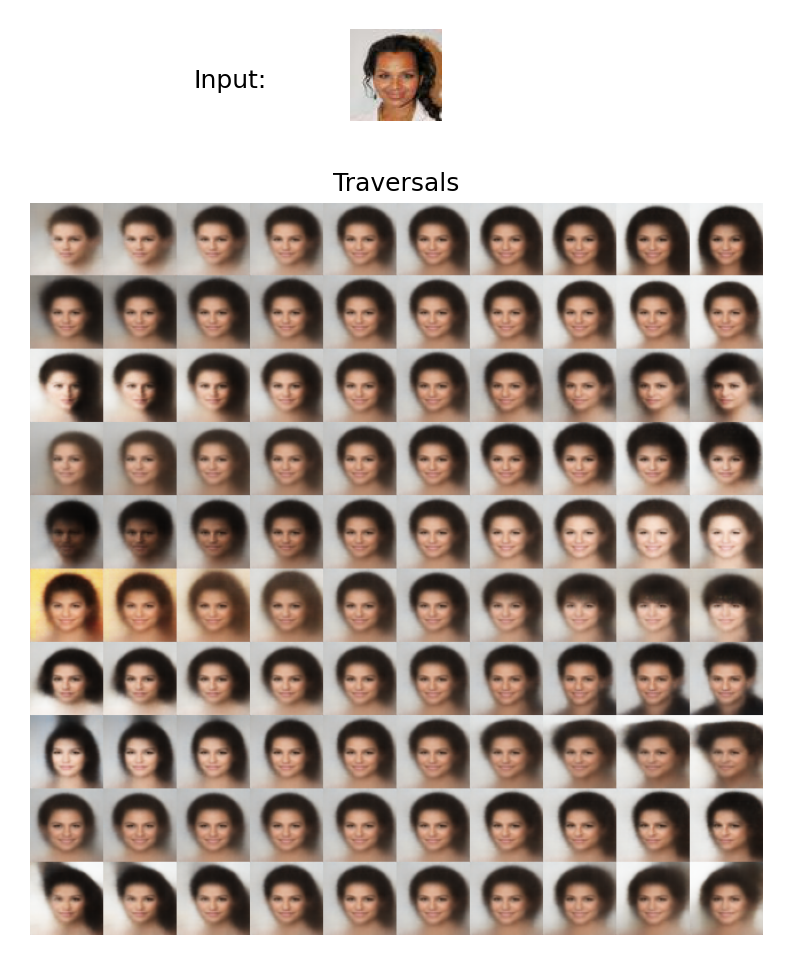

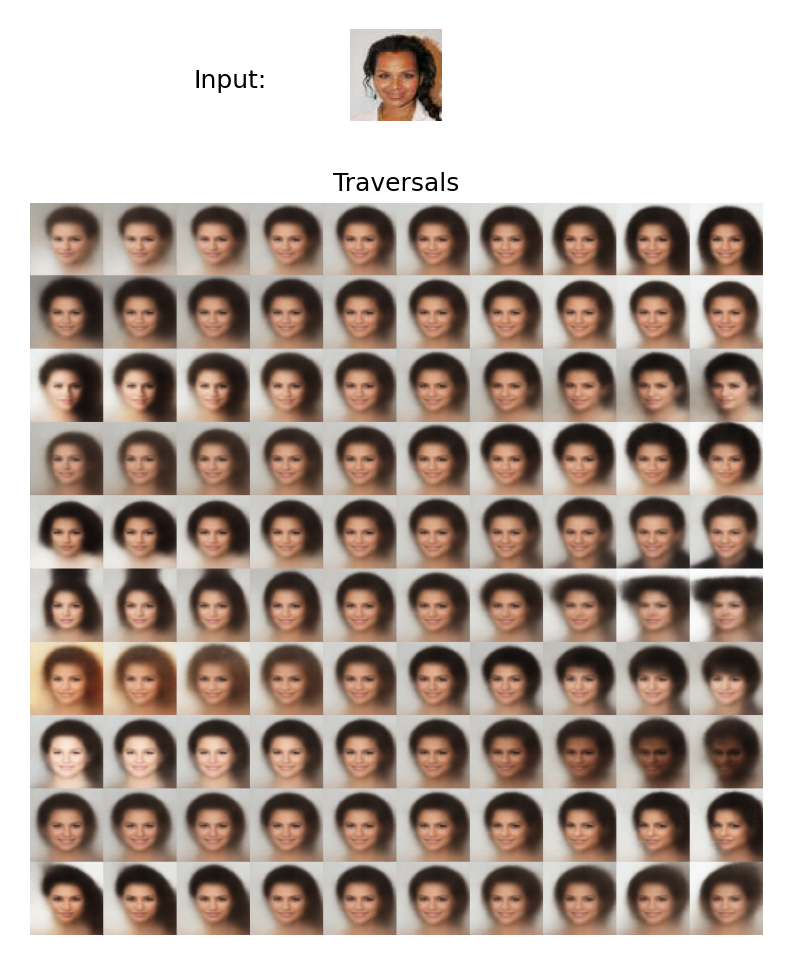

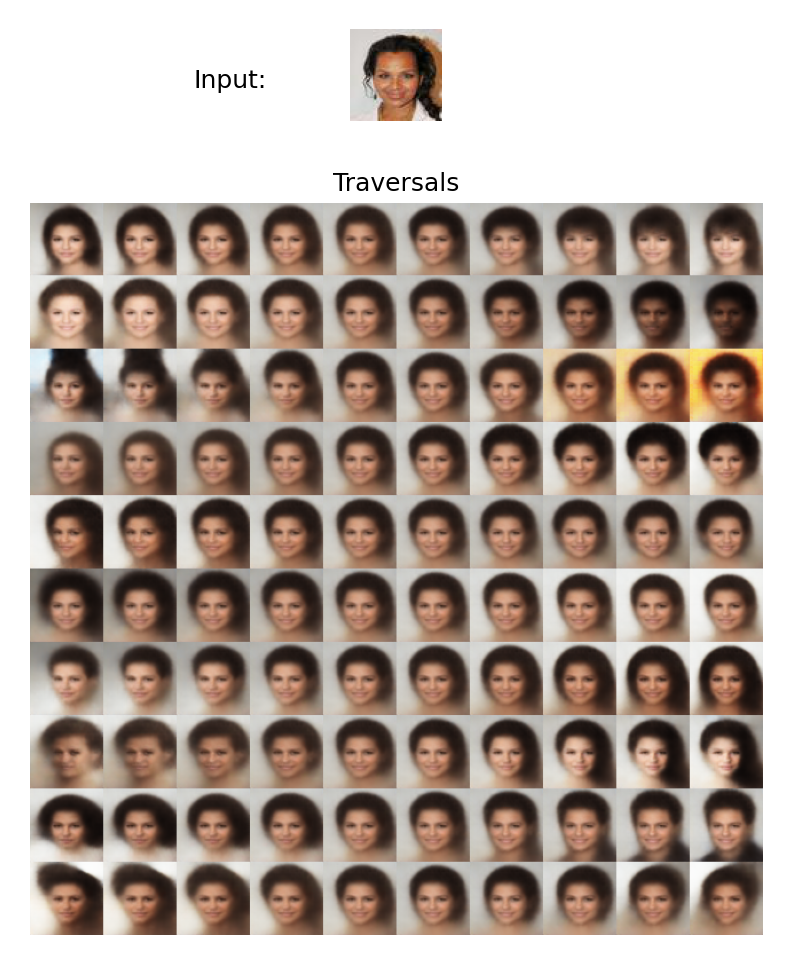

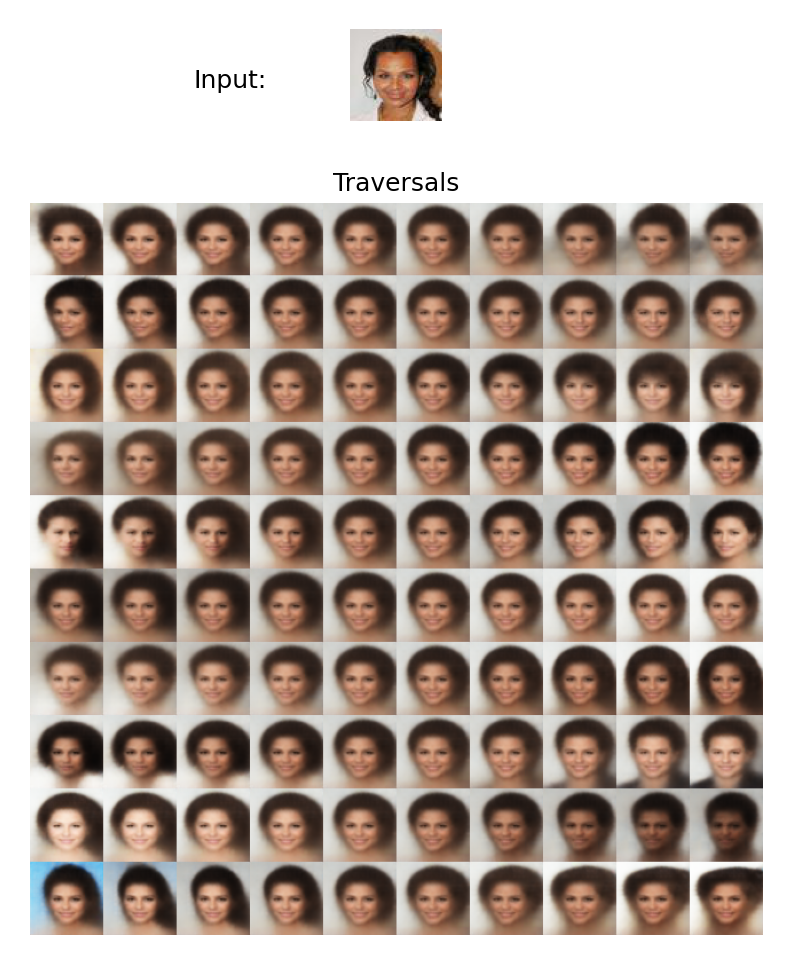

In [11]:
from pathlib import Path
# absolute path
evae_path = Path(qualitative).parent.resolve().expanduser()
main_path = evae_path.parent

for lr in lrs:
    for increment in increments:
        model = main_path / f"results/evae_celeba/{cons}_{epochs}ep_z{nlat}_e{epsilon}_s{seed_model}_lr{lr}_incr{increment}"
        plot_traversals(model, data, lr, increment)